In [1]:
import libraries as lib
import geopandas as gpd
import pandas as pd
import rasterio as rio
import xarray as xr

!pip install openpyxl
import openpyxl

In [2]:
import os
from pathlib import Path
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import xrspatial.multispectral as ms
from xrspatial.focal import mean, focal_stats, hotspots
import stackstac
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import OrderedDict
from shapely.geometry import shape
import rioxarray
from rasterio.crs import CRS
from rasterio.plot import show
import rasterio.features
import itertools
import cartopy.crs as ccrs
import rioxarray
import dask.array as da
import joblib
import xarray as xr
from geopandas import GeoDataFrame
from pandas import Series
from xarray import Dataset
from flox.xarray import xarray_reduce
import warnings

In [3]:
GFW = xr.open_dataset("LossYear_GFW_Fiji.tif")
print(GFW.rio.crs)

EPSG:4326


In [4]:
Harold_34kn = gpd.read_file("Harold_34kn.geojson").fillna(0)
Harold_50kn = gpd.read_file("Harold_50kn.geojson").fillna(0)
Harold_64kn = gpd.read_file("Harold_64kn.geojson").fillna(0)

In [5]:
print(Harold_34kn.crs)
print(Harold_50kn.crs)
print(Harold_64kn.crs)

EPSG:4326
EPSG:4326
EPSG:4326


<Axes: >

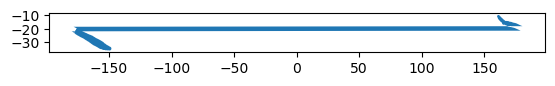

In [6]:
Harold_34kn.plot()

<Axes: >

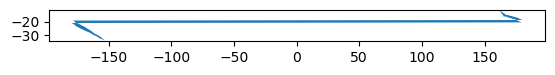

In [7]:
Harold_50kn.plot()

<Axes: >

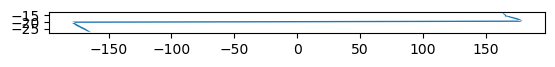

In [8]:
Harold_64kn.plot()

In [9]:
bbox = gpd.read_file("bbox_fiji.geojson")
bbox = bbox.to_crs("EPSG:4326")

In [10]:
import geopandas as gpd
from shapely.geometry import mapping

# Assuming Harold is a GeoDataFrame containing MultiPolygon geometry
geometries_34 = [mapping(geom) for geom in Harold_34kn.geometry]
geometries_50 = [mapping(geom) for geom in Harold_50kn.geometry]
geometries_64 = [mapping(geom) for geom in Harold_64kn.geometry]

# Clip the raster with the extracted geometries
GFW_Harold_34kn = GFW.rio.clip(geometries_34, Harold_34kn.crs)
GFW_Harold_50kn = GFW.rio.clip(geometries_50, Harold_50kn.crs)
GFW_Harold_64kn = GFW.rio.clip(geometries_64, Harold_64kn.crs)

In [11]:

print(GFW.rio.bounds())  # Print the bounds of the raster
print(bbox.total_bounds)  # Print the bounds of the geometry

print(GFW.rio.bounds())  # Print the bounds of the raster
print(bbox.total_bounds)  # Print the bounds of the geometry

bbox = bbox.to_crs(GFW.rio.crs)  # Reproject geometry to match raster CRS
bbox_geometry = [geom for geom in bbox['geometry'].values if geom.is_valid]


(176.78846280169938, -19.371546897773065, 181.8643933146167, -15.95920645951665)
[177.08974852 -19.29811244 179.97866454 -15.80369129]
(176.78846280169938, -19.371546897773065, 181.8643933146167, -15.95920645951665)
[177.08974852 -19.29811244 179.97866454 -15.80369129]


In [12]:
from rioxarray.exceptions import NoDataInBounds

try:
    GFW_Harold_34kn = GFW.rio.clip(bbox_geometry, Harold_34kn.crs)
except NoDataInBounds as e:
    print("No data found within the clipping bounds.")

In [13]:
# # Plot a specific variable
# GFW_Harold_34kn['band_data'].plot(robust=True, cmap='viridis')
# # Show the plot
# plt.show()

In [14]:
# # Plot a specific variable
# GFW_Harold_50kn['band_data'].plot(robust=True, cmap='viridis')
# # Show the plot
# plt.show()

In [15]:
# # Plot a specific variable
# GFW_Harold_64kn['band_data'].plot(robust=True, cmap='viridis')
# # Show the plot
# plt.show()

In [16]:
# GFW_Harold_34kn.head()

In [17]:
GFW.head()

<xarray.Dataset> Size: 196B
Dimensions:      (band: 1, x: 5, y: 5)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 40B 176.8 176.8 176.8 176.8 176.8
  * y            (y) float64 40B -15.96 -15.96 -15.96 -15.96 -15.96
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float32 100B ...

In [18]:
tif_file = ("LossYear_GFW_Fiji.tif")

In [19]:
# Sachin's stats function
def get_stats(tif_file):
    da = rioxarray.open_rasterio(tif_file,
    default_name="year",
    chunks =True,
    ).squeeze()
    
    years = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
    summary = xarray_reduce(da, da, func="count", expected_groups=years)
    summary = summary.to_pandas()
    summary = summary.to_frame()
    df = summary
    df.rename(columns={0: "pixel_count"}, inplace=True)
    total = df.sum().to_numpy()[0]
    df["percent"] = (df["pixel_count"] / total) * 100
    df["class"] = ""
    df.loc[df.index == 1, "class"] = "2001"
    df.loc[df.index == 2, "class"] = "2002"
    df.loc[df.index == 3, "class"] = "2003"
    df.loc[df.index == 4, "class"] = "2004"
    df.loc[df.index == 5, "class"] = "2005"
    df.loc[df.index == 6, "class"] = "2006"
    df.loc[df.index == 7, "class"] = "2007"
    df.loc[df.index == 8, "class"] = "2008"
    df.loc[df.index == 9, "class"] = "2009"
    df.loc[df.index == 10, "class"] = "2010"
    df.loc[df.index == 11, "class"] = "2011"
    df.loc[df.index == 12, "class"] = "2012"
    df.loc[df.index == 13, "class"] = "2013"
    df.loc[df.index == 14, "class"] = "2014"
    df.loc[df.index == 15, "class"] = "2015"
    df.loc[df.index == 16, "class"] = "2016"
    df.loc[df.index == 17, "class"] = "2017"
    df.loc[df.index == 18, "class"] = "2018"
    df.loc[df.index == 19, "class"] = "2019"
    df.loc[df.index == 20, "class"] = "2020"
    df.loc[df.index == 21, "class"] = "2021"
    df.loc[df.index == 22, "class"] = "2022"
    df.loc[df.index == 23, "class"] = "2023"
    df = df[["class", "pixel_count", "percent"]]
    return df

In [20]:
GFW_totals = get_stats(tif_file)
GFW_totals

,class,pixel_count,percent
year,,,
1,2001,13075,1.937014
2,2002,8292,1.228430
3,2003,18534,2.745745
4,2004,24734,3.664253
5,2005,19622,2.906929
6,2006,22065,3.268850
7,2007,25271,3.743807
8,2008,28088,4.161136
9,2009,21028,3.115222


In [21]:
sum_total = GFW_totals['percent'].sum()
sum_total

100.00000000000004

In [22]:
def get_stats(dataset):
    da = dataset["band_data"].squeeze()  # Assuming 'band_data' is the variable name
    years = list(range(1, 24))

    # Assuming xarray_reduce is correctly defined for DataArray
    summary = xarray_reduce(da, da, func="count", expected_groups=years)

    return summary

In [23]:
stats_GFW_Harold_34kn = get_stats(GFW_Harold_34kn)
stats_GFW_Harold_34kn

<xarray.DataArray 'band_data' (band_data: 23)> Size: 184B
array([ 13061,   8278,  18492,  24728,  19597,  21993,  25236,  28077,
        20964,  27578,   6459,  15150,  35000,  50125,  24954, 113176,
        41015,  18028,  19659,  26673,  91974,  13115,  11213])
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0
  * band_data    (band_data) int64 184B 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23
Attributes:
    AREA_OR_POINT:  Area
    long_name:      lossyear

In [24]:
stats_GFW_Harold_50kn = get_stats(GFW_Harold_50kn)
stats_GFW_Harold_50kn

<xarray.DataArray 'band_data' (band_data: 23)> Size: 184B
array([ 7230,  5019, 10571, 13167,  6170, 12303, 13304, 10281,  7638,
       10639,  2509,  7110,  9027,  9074,  4749,  4257,  7146,  6215,
        7635,  7333, 11587,  4072,  3187])
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0
  * band_data    (band_data) int64 184B 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23
Attributes:
    AREA_OR_POINT:  Area
    long_name:      lossyear

In [25]:
stats_GFW_Harold_64kn = get_stats(GFW_Harold_64kn)
stats_GFW_Harold_64kn

<xarray.DataArray 'band_data' (band_data: 23)> Size: 184B
array([ 70,  64,  90, 252,  43, 125,  80,  75, 124, 140,   4, 238, 139,
       265,  74, 199,  94, 388, 374, 886, 312, 178, 447])
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0
  * band_data    (band_data) int64 184B 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23
Attributes:
    AREA_OR_POINT:  Area
    long_name:      lossyear

In [26]:
stats_GFW_Harold_34kn

<xarray.DataArray 'band_data' (band_data: 23)> Size: 184B
array([ 13061,   8278,  18492,  24728,  19597,  21993,  25236,  28077,
        20964,  27578,   6459,  15150,  35000,  50125,  24954, 113176,
        41015,  18028,  19659,  26673,  91974,  13115,  11213])
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0
  * band_data    (band_data) int64 184B 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23
Attributes:
    AREA_OR_POINT:  Area
    long_name:      lossyear

In [27]:
stats_GFW_Harold_50kn

<xarray.DataArray 'band_data' (band_data: 23)> Size: 184B
array([ 7230,  5019, 10571, 13167,  6170, 12303, 13304, 10281,  7638,
       10639,  2509,  7110,  9027,  9074,  4749,  4257,  7146,  6215,
        7635,  7333, 11587,  4072,  3187])
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0
  * band_data    (band_data) int64 184B 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23
Attributes:
    AREA_OR_POINT:  Area
    long_name:      lossyear

In [28]:
stats_GFW_Harold_64kn

<xarray.DataArray 'band_data' (band_data: 23)> Size: 184B
array([ 70,  64,  90, 252,  43, 125,  80,  75, 124, 140,   4, 238, 139,
       265,  74, 199,  94, 388, 374, 886, 312, 178, 447])
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0
  * band_data    (band_data) int64 184B 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23
Attributes:
    AREA_OR_POINT:  Area
    long_name:      lossyear

In [29]:
summary_GFW_Harold_34kn = stats_GFW_Harold_34kn.to_pandas()  # Converts to pandas Series
summary_GFW_Harold_34kn = summary_GFW_Harold_34kn.to_frame(name="34 knots")  # Converts Series to DataFrame
print(summary_GFW_Harold_34kn)

           34 knots
band_data          
1             13061
2              8278
3             18492
4             24728
5             19597
6             21993
7             25236
8             28077
9             20964
10            27578
11             6459
12            15150
13            35000
14            50125
15            24954
16           113176
17            41015
18            18028
19            19659
20            26673
21            91974
22            13115
23            11213


In [30]:
summary_GFW_Harold_50kn = stats_GFW_Harold_50kn.to_pandas()  # Converts to pandas Series
summary_GFW_Harold_50kn = summary_GFW_Harold_50kn.to_frame(name="50 knots")  # Converts Series to DataFrame
print(summary_GFW_Harold_50kn)

           50 knots
band_data          
1              7230
2              5019
3             10571
4             13167
5              6170
6             12303
7             13304
8             10281
9              7638
10            10639
11             2509
12             7110
13             9027
14             9074
15             4749
16             4257
17             7146
18             6215
19             7635
20             7333
21            11587
22             4072
23             3187


In [31]:
summary_GFW_Harold_64kn = stats_GFW_Harold_64kn.to_pandas()  # Converts to pandas Series
summary_GFW_Harold_64kn = summary_GFW_Harold_64kn.to_frame(name="64 knots")  # Converts Series to DataFrame
print(summary_GFW_Harold_64kn)

           64 knots
band_data          
1                70
2                64
3                90
4               252
5                43
6               125
7                80
8                75
9               124
10              140
11                4
12              238
13              139
14              265
15               74
16              199
17               94
18              388
19              374
20              886
21              312
22              178
23              447


In [32]:
GFW_Fiji_km2 = pd.read_csv("Tree_cover_loss_km2_FJ.csv")
GFW_Fiji_km2

,Year,km_2
0,2001,10.97
1,2002,7.03
2,2003,15.73
3,2004,20.79
4,2005,16.66
5,2006,18.75
6,2007,21.49
7,2008,23.87
8,2009,17.90
9,2010,23.46


In [33]:
df_horizontal = pd.concat([summary_GFW_Harold_34kn, summary_GFW_Harold_50kn, summary_GFW_Harold_64kn, GFW_totals['pixel_count']], axis=1)

In [34]:
join_column = GFW_Fiji_km2['Year']
df1 = df_horizontal.merge(GFW_Fiji_km2[['Year', 'km_2']], on=join_column, how='left')
df1

,key_0,34 knots,50 knots,64 knots,pixel_count,Year,km_2
0,2001,13061,7230,70,13075,2001,10.97
1,2002,8278,5019,64,8292,2002,7.03
2,2003,18492,10571,90,18534,2003,15.73
3,2004,24728,13167,252,24734,2004,20.79
4,2005,19597,6170,43,19622,2005,16.66
5,2006,21993,12303,125,22065,2006,18.75
6,2007,25236,13304,80,25271,2007,21.49
7,2008,28077,10281,75,28088,2008,23.87
8,2009,20964,7638,124,21028,2009,17.90
9,2010,27578,10639,140,27644,2010,23.46


In [35]:
df = df1
df['34kn_%'] = df['34 knots']/df['pixel_count']*100
df['50kn_%'] = df['50 knots']/df['pixel_count']*100
df['64kn_%'] = df['64 knots']/df['pixel_count']*100
df['km_2'] = GFW_Fiji_km2['km_2']
df

,key_0,34 knots,50 knots,64 knots,pixel_count,Year,km_2,34kn_%,50kn_%,64kn_%
0,2001,13061,7230,70,13075,2001,10.97,99.892925,55.296367,0.535373
1,2002,8278,5019,64,8292,2002,7.03,99.831163,60.528220,0.771828
2,2003,18492,10571,90,18534,2003,15.73,99.773389,57.035718,0.485594
3,2004,24728,13167,252,24734,2004,20.79,99.975742,53.234414,1.018840
4,2005,19597,6170,43,19622,2005,16.66,99.872592,31.444297,0.219142
5,2006,21993,12303,125,22065,2006,18.75,99.673691,55.757988,0.566508
6,2007,25236,13304,80,25271,2007,21.49,99.861501,52.645325,0.316568
7,2008,28077,10281,75,28088,2008,23.87,99.960837,36.602820,0.267018
8,2009,20964,7638,124,21028,2009,17.90,99.695644,36.322998,0.589690
9,2010,27578,10639,140,27644,2010,23.46,99.761250,38.485747,0.506439


In [36]:
df = df.drop(columns=['Year'])


In [37]:
df = df.rename(columns={'key_0':'Year'})
df

,Year,34 knots,50 knots,64 knots,pixel_count,km_2,34kn_%,50kn_%,64kn_%
0,2001,13061,7230,70,13075,10.97,99.892925,55.296367,0.535373
1,2002,8278,5019,64,8292,7.03,99.831163,60.528220,0.771828
2,2003,18492,10571,90,18534,15.73,99.773389,57.035718,0.485594
3,2004,24728,13167,252,24734,20.79,99.975742,53.234414,1.018840
4,2005,19597,6170,43,19622,16.66,99.872592,31.444297,0.219142
5,2006,21993,12303,125,22065,18.75,99.673691,55.757988,0.566508
6,2007,25236,13304,80,25271,21.49,99.861501,52.645325,0.316568
7,2008,28077,10281,75,28088,23.87,99.960837,36.602820,0.267018
8,2009,20964,7638,124,21028,17.90,99.695644,36.322998,0.589690
9,2010,27578,10639,140,27644,23.46,99.761250,38.485747,0.506439


In [38]:
df.set_index('Year', inplace=True)



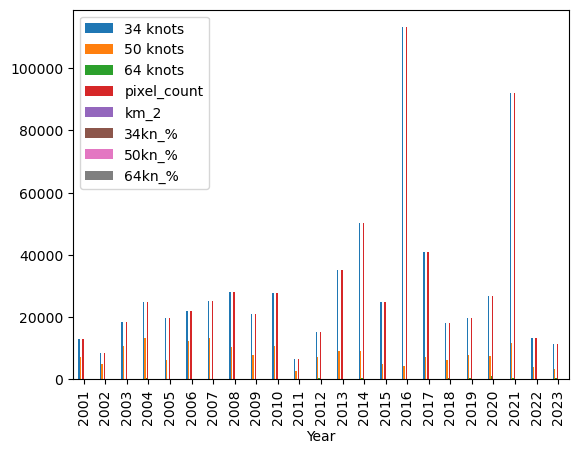

In [39]:
# Plot a bar chart
df.plot(kind='bar', legend=True)
plt.show()

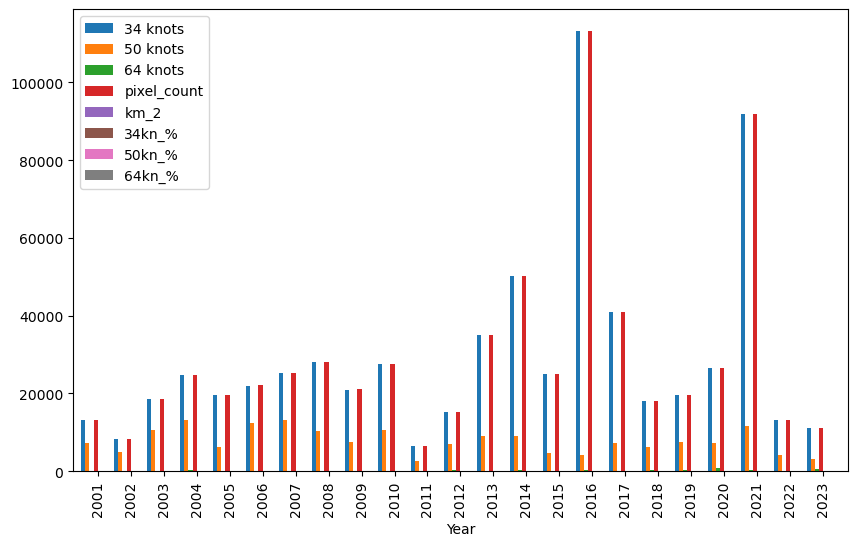

In [40]:
ax = df.plot(kind='bar', figsize=(10, 6), width=1, legend=True)

In [41]:
df.to_excel("Harold_2016_swaths_GFW.xlsx")

In [48]:
Harold_df = df.iloc[[19]]
Harold_df


,34 knots,50 knots,64 knots,pixel_count,km_2,34kn_%,50kn_%,64kn_%
Year,,,,,,,,
2020,26673,7333,886,26676,20.67,99.988754,27.489129,3.321338


In [49]:
Harold_df["34 knots swath km2"] = Harold_df["km_2"]*((Harold_df["34kn_%"])/100)
Harold_df["50 knots swath km2"] = Harold_df["km_2"]*((Harold_df["50kn_%"])/100)
Harold_df["64 knots swath km2"] = Harold_df["km_2"]*((Harold_df["64kn_%"])/100)
Harold_df

,34 knots,50 knots,64 knots,pixel_count,km_2,34kn_%,50kn_%,64kn_%,34 knots swath km2,50 knots swath km2,64 knots swath km2
Year,,,,,,,,,,,
2020,26673,7333,886,26676,20.67,99.988754,27.489129,3.321338,20.667675,5.682003,0.68652


In [50]:
Harold_df["national tree cover loss km2"] = Harold_df["km_2"] - Harold_df["34 knots swath km2"]
Harold_df = Harold_df.drop(columns=['34 knots', '50 knots', '64 knots', 'pixel_count', 'km_2', '34kn_%', '50kn_%', '64kn_%'])
Harold_df

,34 knots swath km2,50 knots swath km2,64 knots swath km2,national tree cover loss km2
Year,,,,
2020,20.667675,5.682003,0.68652,0.002325


In [51]:
col_order = ['64 knots', '50 knots', '34 knots', 'national tree cover loss km2']
colors = ['maroon', 'orange', 'yellow', 'grey']

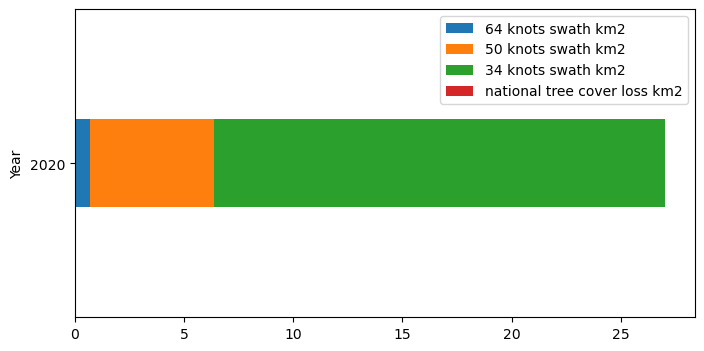

In [52]:
ax_Harold = Harold_df.plot(kind='barh', y=['64 knots swath km2', '50 knots swath km2','34 knots swath km2', 'national tree cover loss km2'], stacked=True, figsize=(8, 4), width=0.2, legend=True)

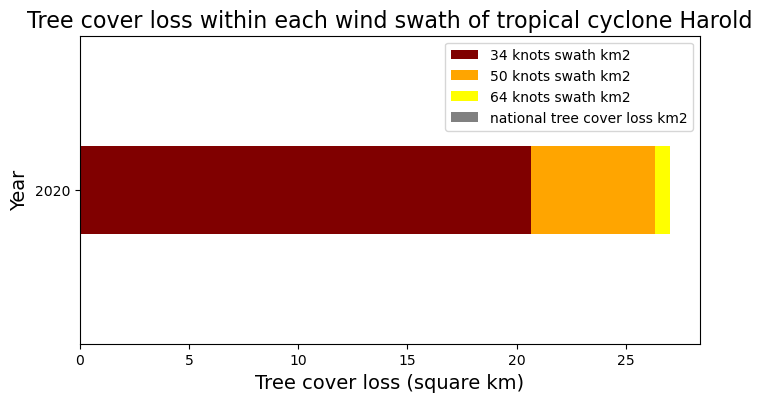

In [53]:
# List of colors for each bar
colors = ['maroon', 'orange', 'yellow', 'grey']

# Plot the bar chart with specific colors for each bar
ax = Harold_df.plot(kind='barh', color=colors, stacked=True, width=0.2, figsize=(8, 4), legend=True)

# Set title and labels
ax.set_title('Tree cover loss within each wind swath of tropical cyclone Harold', fontsize=16)
ax.set_xlabel('Tree cover loss (square km)', fontsize=14)
ax.set_ylabel('Year', fontsize=14)

# Display the plot
plt.show()